## Importação das bibliotecas

A transferência de aprendizado em machine learning é aproveitar os recursos de um modelo e ensinar coisas novas a ele.

Nesse projeto foi aproveitado o modelo MobileNetV2 e utilizou as bibliotecas keras e tensorflow para redes neurais

O método geralmente é feito para tarefas em que seu conjunto de dados tem poucos dados para treinar um modelo do zero.

Será passado fotos de rosas e margaridas para treinamento com pequeno número de amostras

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from IPython.display import display
from PIL import Image

## Carregamento das imagens

Para o Teste (validação) foram separadas 202 imagens dividas entre rosas (101) e margaridas (101).

As imagens foram selecionadas à partir https://www.kaggle.com/datasets/alxmamaev/flowers-recognition.

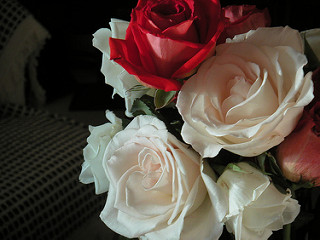

In [5]:
# visualizando um imagem da pasta de treinamento Rosa.
tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/Projetos/Flowers ML/Rosas/102501987_3cdb8e5394_n.jpg")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


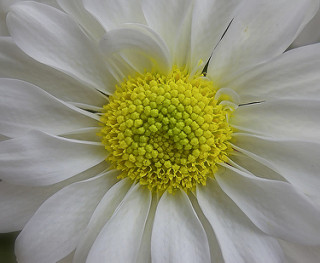

In [7]:
# visualizando um imagem da pasta de treinamento Margarida.
tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/Projetos/Flowers ML/Margaridas/100080576_f52e8ee070_n.jpg")

## Base de dados de treinamento e teste

### Aumento de dados aleatórios

Irá introduzir rotação, zoom nas imagens, com isso aumenta a amostra e também diversifica o tipo de imagem de uma maneira artificial, será realizado para produzir alguns tipos de imagens que não pode ter na base de dados. Deseja introduzir diversidade de imagens na base de dados

Será utilizado o métdo ImageDataGenerator

In [8]:
# realizando o redimensionamento e a normalização no conjunto de treinamento.
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
path_training=r"/content/drive/MyDrive/Projetos/Flowers ML"
dataset_treinamento = gerador_treinamento.flow_from_directory(path_training,
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 202 images belonging to 2 classes.


In [9]:
# realizando o redimensionamento e a normalização no conjunto de teste. 
gerador_teste = ImageDataGenerator(rescale=1./255)
path_test=r"/content/drive/MyDrive/Projetos/Flower train"
dataset_teste = gerador_teste.flow_from_directory(path_test,
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 202 images belonging to 2 classes.


## Rede neural pré-treinada

Será utilizado o modelo MobileNetV2 que já foi treinado para outros fins

Será utilizado todos os pesos das camadas do modelo que já foi treinado(know-how) e implementar apenas as camadas finais para o objetivo proposto que é classificar se a flor é uma rosa ou margarida

Isso reduzirá o tempo de treinamento já que criar uma rede neural do zero demanda tempo além de custo computacional (placa de video ou muita memória ram e bom processador)

In [10]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [12]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [13]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
    layer.trainable = False

## Camada densa ajustada

In [14]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

A última camada possui 1280 conexões para realizar a ligação com a nova camada foi utilizado a metade dessas conexões

Dropout irá descartar 20% das conexões para próxima camada, espera que não haja overfitting com essa redução ou o diminua

Foi criada uma camada densa de 2 conexões para classificação (rosa,margarida)

In [15]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

## Construção e treinamento da rede neural

In [16]:
# ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [17]:
# mostra as informações das camadas.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [18]:
# Adiciona as 6 camadas finais ao modelo.
len(network.layers)

160

In [19]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [20]:
# Realizando o treimanto com 10 epocas.
historico = network.fit(dataset_treinamento, epochs=10)

Epoch 1/10
2/2 [==============================] - 24s 713ms/step - loss: 0.6857 - accuracy: 0.6634
Epoch 2/10
2/2 [==============================] - 2s 542ms/step - loss: 0.4962 - accuracy: 0.8317
Epoch 3/10
2/2 [==============================] - 2s 992ms/step - loss: 0.1007 - accuracy: 0.9554
Epoch 4/10
2/2 [==============================] - 2s 566ms/step - loss: 0.1556 - accuracy: 0.9406
Epoch 5/10
2/2 [==============================] - 2s 984ms/step - loss: 0.0604 - accuracy: 0.9802
Epoch 6/10
2/2 [==============================] - 2s 781ms/step - loss: 0.1166 - accuracy: 0.9604
Epoch 7/10
2/2 [==============================] - 2s 657ms/step - loss: 0.0645 - accuracy: 0.9802
Epoch 8/10
2/2 [==============================] - 2s 550ms/step - loss: 0.0206 - accuracy: 0.9950
Epoch 9/10
2/2 [==============================] - 2s 534ms/step - loss: 0.0175 - accuracy: 0.9950
Epoch 10/10
2/2 [==============================] - 2s 960ms/step - loss: 0.0180 - accuracy: 0.9901


## Avaliação da rede neural

In [21]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

202/202 [==============================] - 44s 213ms/step - loss: 0.1843 - accuracy: 0.9356


[0.18433982133865356, 0.9356435537338257]

In [22]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

202/202 [==============================] - 2s 8ms/step


array([[9.99997735e-01, 2.24158407e-06],
       [9.99998212e-01, 1.81332518e-06],
       [9.99506116e-01, 4.93914471e-04],
       [6.46647930e-01, 3.53352100e-01],
       [6.84207797e-01, 3.15792233e-01],
       [9.94499326e-01, 5.50068775e-03],
       [9.99923468e-01, 7.65147779e-05],
       [9.20330048e-01, 7.96699151e-02],
       [9.99928236e-01, 7.17537114e-05],
       [9.99964237e-01, 3.58113721e-05],
       [9.99972224e-01, 2.77845938e-05],
       [9.99942780e-01, 5.72650861e-05],
       [9.99999285e-01, 6.62325135e-07],
       [9.99761045e-01, 2.38918874e-04],
       [9.99482393e-01, 5.17532870e-04],
       [9.94201362e-01, 5.79855544e-03],
       [9.98960614e-01, 1.03936403e-03],
       [9.99970317e-01, 2.96330381e-05],
       [9.99920011e-01, 8.00221969e-05],
       [9.99994516e-01, 5.49959714e-06],
       [9.99989390e-01, 1.06233656e-05],
       [9.91460919e-01, 8.53903219e-03],
       [9.99811709e-01, 1.88361431e-04],
       [9.99999762e-01, 2.73850731e-07],
       [9.998152

In [23]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
# classificação real do conjunto de teste.
dataset_teste.classes[:10] # 10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [25]:
# função sklearn apenas para avaliar a acurácia do modelo
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.9356435643564357

In [26]:
network.evaluate(dataset_teste)

202/202 [==============================] - 2s 9ms/step - loss: 0.1843 - accuracy: 0.9356


[0.18433982133865356, 0.9356435537338257]

Conforme o resultado, o modelo teve 94.06% de acurácia no conjunto de teste.

## Plotar matriz de confusão

In [27]:
dataset_treinamento.class_indices

{'Margaridas': 0, 'Rosas': 1}

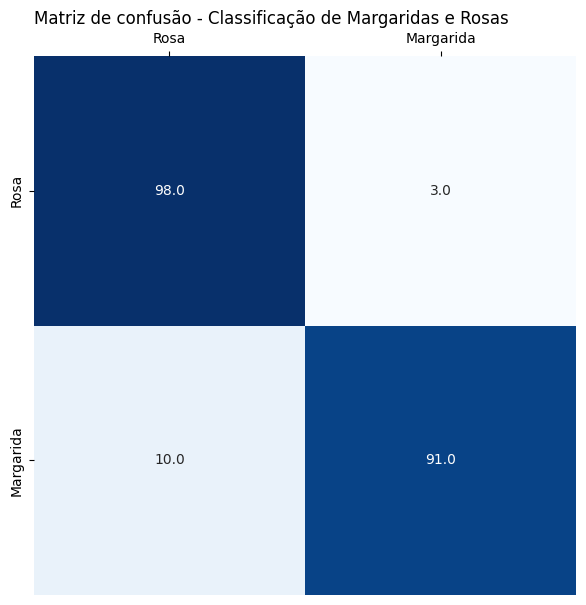

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Rosa', 'Margarida']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Rosa', 'Margarida']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Margaridas e Rosas'
plt.title(title, loc='left')
plt.show()

O modelo acertou 96 Rosas e errou 5

O modelo acertou 94 Margarida e errou 7

**Porcentagem de erro bem parecido para as duas classes**

**Margarida = (7/101)*100= 6,93%**

**Rosa = (5/101)*100= 4,95%**

In [29]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       101
           1       0.97      0.90      0.93       101

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202



O modelo teve um resultado satisfatório para detectar ambas imagens

## Salvar e carregar a rede neural

In [30]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
    json_file.write(model_json)

In [31]:
# Salvando os pesos das camadas.
from google.colab import drive
drive.mount('/content/drive')

from keras.models import save_model
network_saved = save_model(network, '/content/drive/MyDrive/Projetos/Flowers Pesos')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
    json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "Conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "bn_Conv1", "trainable": false, "dtype

In [33]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights(r"/content/drive/MyDrive/Projetos/Flowers Pesos")
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [34]:
# conferindo as informações das camadas.
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

## Classificação de uma única imagem

Simular uma aplicação: Identificar imagens dentro de uma pasta se tem rosas ou margaridas.

Irá testar com uma imagem qual tipo de flor trata-se, se uma rosa ou uma margarida.

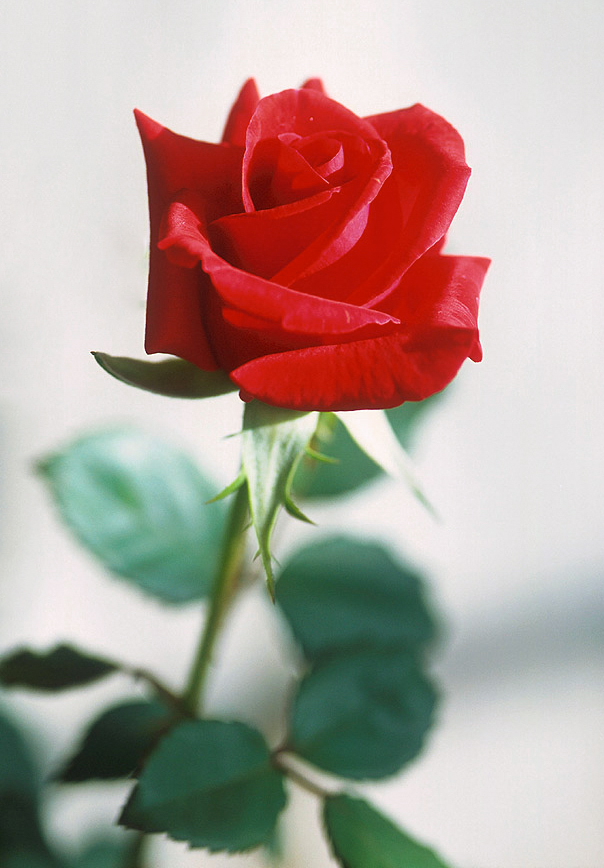

In [35]:
# carregando uma imagem
path_rosa=r"/content/drive/MyDrive/Red_rose.jpg"
display(Image.open(path_rosa))
imagem_rosa = np.array(Image.open(path_rosa))
real=1

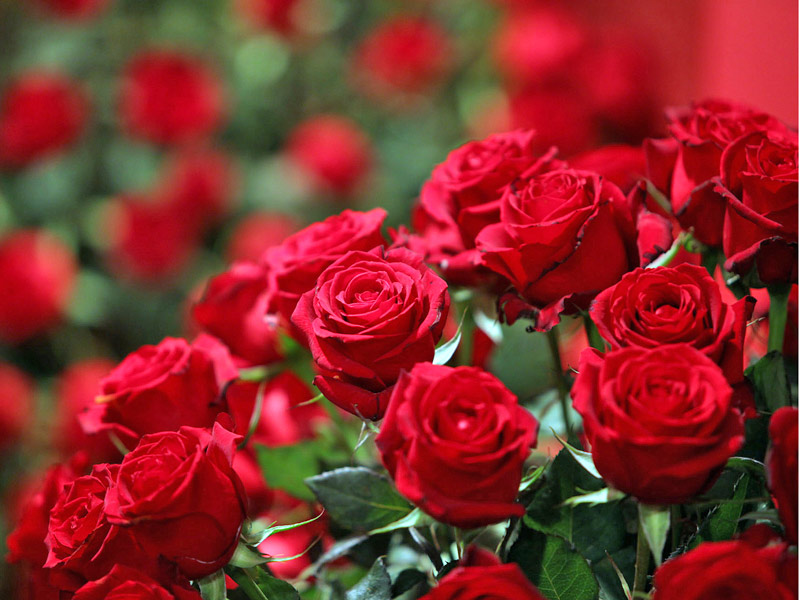

In [36]:
# carregando uma imagem
path_rosa=r"/content/drive/MyDrive/Rosa-sp-10.jpg"
display(Image.open(path_rosa))
imagem_rosa2 = np.array(Image.open(path_rosa))
real=1

In [37]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_rosa  = cv2.resize(imagem_rosa , (128, 128))
imagem_rosa  = cv2.rotate(imagem_rosa , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [38]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_rosa2  = cv2.resize(imagem_rosa2 , (128, 128))
imagem_rosa2  = cv2.rotate(imagem_rosa2 , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [39]:
# Normalizando a imagem.
imagem_rosa  = imagem_rosa/255

In [40]:
# Normalizando a imagem.
imagem_rosa2  = imagem_rosa2/255

In [41]:
# Conferindo o formato
imagem_rosa.shape

(128, 128, 3)

In [42]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_rosa  = imagem_rosa.reshape(1,128,128,3)

In [43]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_rosa2  = imagem_rosa2.reshape(1,128,128,3)

In [44]:
# Realizando a previsão.
previsao = network_loaded(imagem_rosa)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.5057214e-05, 9.9992490e-01]], dtype=float32)>

In [45]:
previsao_class = np.argmax(previsao)
previsao_class

1

In [46]:
dataset_teste.class_indices

{'Margaridas': 0, 'Rosas': 1}

In [47]:
if previsao_class == 0:
    print('O modelo identificou que a flor é uma margarida')
else:
    print('O modelo identificou que a flor é uma rosa')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que a flor é uma rosa
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 99.99%


In [48]:
# Realizando a previsão.
previsao = network_loaded(imagem_rosa2)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.3570888e-05, 9.9998641e-01]], dtype=float32)>

In [49]:
previsao_class = np.argmax(previsao)
previsao_class

1

In [50]:
if previsao_class == 0:
    print('O modelo identificou que a flor é uma margarida')
else:
    print('O modelo identificou que a flor é uma rosa')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que a flor é uma rosa
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 100.00%


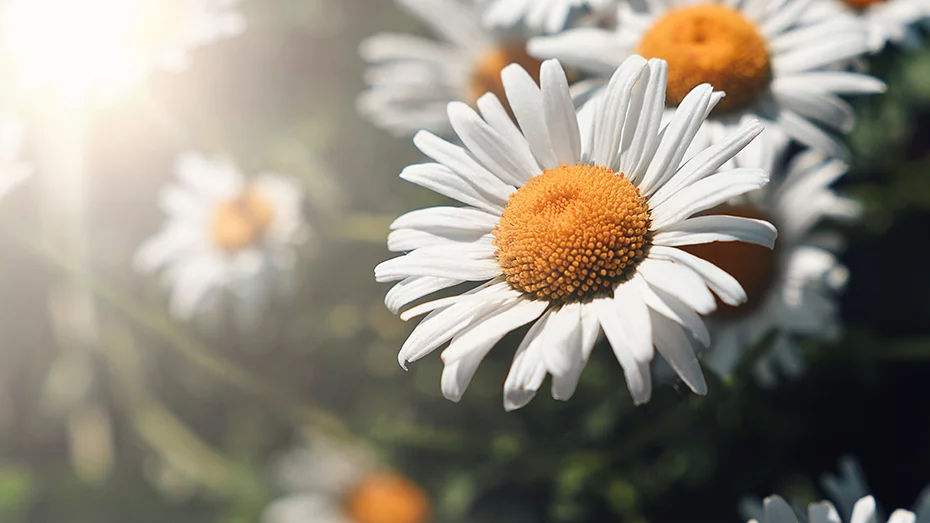

In [51]:
# Teste com margarida
# carregando uma imagem
path_margarida=r"/content/drive/MyDrive/Margarida1.webp"
display(Image.open(path_margarida))
imagem_margarida = np.array(Image.open(path_margarida))
real=0

In [52]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_margarida = cv2.resize(imagem_margarida, (128, 128))
imagem_margarida = cv2.rotate(imagem_margarida, cv2.ROTATE_90_COUNTERCLOCKWISE)

In [53]:
# Normalizando a imagem.
imagem_margarida = imagem_margarida / 255

In [54]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_margarida = imagem_margarida.reshape(1,128,128,3)

In [55]:
# Realizando a previsão.
previsao = network_loaded(imagem_margarida)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.999993e-01, 6.766094e-07]], dtype=float32)>

In [56]:
previsao_class = np.argmax(previsao)
previsao_class

0

In [57]:
if previsao_class == 0:
    print('O modelo identificou que a flor é uma margarida')
else:
    print('O modelo identificou que a flor é uma rosa')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que a flor é uma margarida
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 100.00%
